In [1]:
import re
import json
import math
import random
import numpy as np
from enum import Enum
from typing import List, Dict, Optional, Any
from dataclasses import dataclass
from langchain_ollama import OllamaLLM

# Reasoning Component for LLMs using MCTS 

In [2]:
class ReasoningStrategy(Enum):
  "Estrategias de razonamiento disponibles"
  ANALYTICAL = "analytical"
  CREATIVE = "creative" 
  CRITICAL = "critical"
  EXPLORATORY = "exploratory"

@dataclass
class ThoughtNode:
  "Nodo que representa un fragmento de pensamiento en el árbol de razonamiento"
  topic:str
  thought: str
  reasoning_strategy: ReasoningStrategy
  depth: int
  parent: Optional['ThoughtNode'] = None
  children: List['ThoughtNode'] = None
  visits: int = 0
  value: float = 0.0
  confidence: float = 0.0
  
  def __post_init__(self):
    if self.children is None:
      self.children = []

  def is_fully_expanded(self, max_children:int) -> bool:
    "Verifica si el nodo está completamente expandido"
    return len(self.children) >= max_children
  
  def get_path_to_root(self) -> List['ThoughtNode']:
    "Obtiene el camino desde este nodo hasta la raíz"
    path = []
    current = self
    while current is not None:
      path.append(current)
      current = current.parent
    return list(reversed(path))
  
  def get_reasoning_chain(self) -> str:
    "Obtiene la cadena de razonamiento completa hasta este nodo"
    path = self.get_path_to_root()
    chain = []
    for i, node in enumerate(path):
      chain.append(f"Nivel {i}: [{node.reasoning_strategy.value}] {node.thought}")
    return "\n".join(chain)

In [3]:

strategy_prompt_for_analytical:str = """ 
Eres un experto analista que responde en español con rigor académico.
Contexto de razonamiento desarrollado previamente: {reasoning_context}

Aplicando un ENFOQUE ANALÍTICO riguroso, profundiza en este tema desarrollando:
- Descomposición sistemática del problema en componentes fundamentales
- Análisis detallado de relaciones causa-efecto y dependencias
- Identificación de patrones, tendencias y correlaciones significativas  
- Evaluación crítica de evidencia, datos y fuentes disponibles
- Estructuración lógica de argumentos y conclusiones

Desarrolla un análisis académico detallado, estructurado y fundamentado en español:
"""

strategy_prompt_for_creative:str = """ 
Eres un pensador creativo experto que responde en español con originalidad.
Contexto de razonamiento desarrollado previamente: {reasoning_context}

Aplicando un ENFOQUE CREATIVO innovador, explora este tema desarrollando:
- Pensamiento lateral con analogías, metáforas y conexiones inesperadas
- Perspectivas innovadoras que desafíen paradigmas convencionales
- Escenarios hipotéticos y modelos alternativos de comprensión
- Síntesis creativa entre disciplinas y dominios de conocimiento
- Soluciones originales y enfoques no tradicionales

Genera ideas creativas, originales y bien fundamentadas en español:
"""

strategy_prompt_for_critical:str = """ 
Eres un evaluador crítico experto que responde en español con objetividad.
Contexto de razonamiento desarrollado previamente: {reasoning_context}

Aplicando un ENFOQUE CRÍTICO riguroso, evalúa este tema desarrollando:
- Cuestionamiento sistemático de suposiciones y premisas fundamentales
- Identificación de sesgos, limitaciones y puntos ciegos potenciales
- Evaluación equilibrada de fortalezas, debilidades y riesgos
- Consideración de perspectivas alternativas y contraargumentos
- Análisis de implicaciones éticas, sociales y prácticas

Proporciona una evaluación crítica rigurosa, objetiva y bien argumentada en español:
"""

strategy_prompt_for_exploratory:str = """ 
Eres un investigador exploratorio experto que responde en español con curiosidad científica
Contexto de razonamiento desarrollado previamente: {reasoning_context}

Aplicando un ENFOQUE EXPLORATORIO sistemático, examina este tema desarrollando:
- Investigación multidireccional de aspectos inexplorados
- Formulación de preguntas abiertas y problemas de investigación
- Exploración de implicaciones a corto, medio y largo plazo
- Descubrimiento de nuevas dimensiones y conexiones interdisciplinarias
- Identificación de oportunidades de desarrollo futuro

Explora direcciones prometedoras de investigación con fundamento científico en español:
"""

In [ ]:
#TODO CONTENT
strategy_prompt_for_analytical:str = """ 
Eres un experto analista que responde en español con rigor académico.
Contexto de razonamiento desarrollado previamente: {reasoning_context}

Aplicando un ENFOQUE ANALÍTICO riguroso, profundiza en este tema desarrollando:
- Descomposición sistemática del problema en componentes fundamentales
- Análisis detallado de relaciones causa-efecto y dependencias
- Identificación de patrones, tendencias y correlaciones significativas  
- Evaluación crítica de evidencia, datos y fuentes disponibles
- Estructuración lógica de argumentos y conclusiones

Puedes usar para generar una respuesta mejor argumentada los siguientes fragmentos:
{content}

Desarrolla un análisis académico detallado, estructurado y fundamentado en español:
"""

strategy_prompt_for_creative:str = """ 
Eres un pensador creativo experto que responde en español con originalidad.
Contexto de razonamiento desarrollado previamente: {reasoning_context}

Aplicando un ENFOQUE CREATIVO innovador, explora este tema desarrollando:
- Pensamiento lateral con analogías, metáforas y conexiones inesperadas
- Perspectivas innovadoras que desafíen paradigmas convencionales
- Escenarios hipotéticos y modelos alternativos de comprensión
- Síntesis creativa entre disciplinas y dominios de conocimiento
- Soluciones originales y enfoques no tradicionales

Puedes usar para generar una respuesta mejor argumentada los siguientes fragmentos:
{content}

Genera ideas creativas, originales y bien fundamentadas en español:
"""

strategy_prompt_for_critical:str = """ 
Eres un evaluador crítico experto que responde en español con objetividad.
Contexto de razonamiento desarrollado previamente: {reasoning_context}

Aplicando un ENFOQUE CRÍTICO riguroso, evalúa este tema desarrollando:
- Cuestionamiento sistemático de suposiciones y premisas fundamentales
- Identificación de sesgos, limitaciones y puntos ciegos potenciales
- Evaluación equilibrada de fortalezas, debilidades y riesgos
- Consideración de perspectivas alternativas y contraargumentos
- Análisis de implicaciones éticas, sociales y prácticas

Puedes usar para generar una respuesta mejor argumentada los siguientes fragmentos:
{content}

Proporciona una evaluación crítica rigurosa, objetiva y bien argumentada en español:
"""

strategy_prompt_for_exploratory:str = """ 
Eres un investigador exploratorio experto que responde en español con curiosidad científica
Contexto de razonamiento desarrollado previamente: {reasoning_context}

Aplicando un ENFOQUE EXPLORATORIO sistemático, examina este tema desarrollando:
- Investigación multidireccional de aspectos inexplorados
- Formulación de preguntas abiertas y problemas de investigación
- Exploración de implicaciones a corto, medio y largo plazo
- Descubrimiento de nuevas dimensiones y conexiones interdisciplinarias
- Identificación de oportunidades de desarrollo futuro

Puedes usar para generar una respuesta mejor argumentada los siguientes fragmentos:
{content}

Explora direcciones prometedoras de investigación con fundamento científico en español:
"""

In [4]:
GEMMA = "gemma3:1b"             # ollama gemma3:1b
DEEPSEEK = "deepseek-r1:1.5b"   # ollama deepseek-r1:1.5b

class LLMReasoning: 
  "Componente de razonamiento basado en MCTS para LLMs"
  
  def __init__(self, 
        main_model:str = GEMMA,
        critical_model:str = DEEPSEEK,
        temperature:float = 0.7,
        max_children:int = 3,
        exploration_weight:float = 1.41) -> None:
    """Inicializa el componente de razonamiento

    Args:
        main_model (str, optional): nombre del modelo de lenguaje local a utilizar. Defaults to GEMMA="gemma3:1b".
        critical_model (str, optional): nombre del modelo de lenguaje local a utilizar como crítico. Defaults to DEEPSEEK.
        temperature (float, optional): temperatura para la generación. Defaults to 0.7.
        max_children (int, optional): máximo número de hijos por nodo. Defaults to 3.
        exploration_weight (float, optional): peso de exploración para UCB. Defaults to 1.41.
    """
    self.main_llm = OllamaLLM(model=main_model, temperature=temperature)
    self.critical_llm = OllamaLLM(model=critical_model, temperature=0.9)
    self.max_children = max_children
    self.exploration_weight = exploration_weight
    self.reasoning_strategies = list(ReasoningStrategy)
    
    #TODO add retriever
  
  def expand_thought(self, parent_node:ThoughtNode, strategy:ReasoningStrategy) -> str:
    "Expande un pensamiento utilizando una estrategia específica"
    reasoning_context = parent_node.get_reasoning_chain()
    
    #TODO retriever.get_next_content
    
    strategy_prompts = {
      ReasoningStrategy.ANALYTICAL:  strategy_prompt_for_analytical,
      ReasoningStrategy.CREATIVE:    strategy_prompt_for_creative,
      ReasoningStrategy.CRITICAL:    strategy_prompt_for_critical,
      ReasoningStrategy.EXPLORATORY: strategy_prompt_for_exploratory
    }
    
    prompt = strategy_prompts[strategy].format(reasoning_context=reasoning_context)
    return self.main_llm.invoke(prompt)
  
  def evaluate_thought_quality(self, node:ThoughtNode) -> Dict[str,float]:
    "Evalúa la calidad de un pensamiento"
    prompt = f"""Eres un evaluador académico experto:
    Tema Original: {node.topic}
    
    Pensamiento a evaluar: {node.thought}
    
    Evalúa este pensamiento de manera rigurosa en las siguientes dimensiones usando las categorías: PÉSIMO, MALO, BUENO, EXCELENTE:
    
    1. RELEVANCIA: ¿Qué tan directamente relacionado está con el tema original? ¿Aporta valor específico?
    2. PROFUNDIDAD: ¿Qué tan profundo y detallado es el análisis presentado? ¿Demuestra comprensión compleja?
    3. ORIGINALIDAD: ¿Qué tan original e innovadora es la perspectiva ofrecida? 
    4. CLARIDAD: ¿Qué tan claro, comprensible y bien estructurado está el pensamiento?
    5. UTILIDAD: ¿Qué tan útil es este análisis para comprender mejor el tema original?
    
    INSTRUCCIONES DE FORMATO:
    {{
      "relevancia": pesimo/malo/bueno/excelente
      "profundidad": pesimo/malo/bueno/excelente
      "originalidad": pesimo/malo/bueno/excelente
      "claridad": pesimo/malo/bueno/excelente
      "utilidad": pesimo/malo/bueno/excelente
    }}
    
    Proporciona únicamente las evaluaciones categóricas en el formato exacto indicado y para cada evaluación solo se puede indicar una única categoría (pesimo/malo/bueno/excelente)
    """
    # generar respuesta por LLM crítico
    response = self.critical_llm.invoke(prompt).lower()
    
    # mapeo de conversión de categorías a valores numéricos
    category_mapping = {
      "pesimo": 0, 
      "malo": 1,
      "bueno": 2,
      "excelente": 3
    }
    
    # Buscar el primer bloque que parezca un JSON en la respuesta
    json_match = re.search(r'\{.*?\}', response, re.DOTALL)
    if json_match:
      try:
        scores = json.loads(json_match.group(0).replace('\n', '').replace('\r', '').replace(' ', ''))
        for key in scores:
          scores[key] = category_mapping.get(str(scores[key]), 1.0)
      except Exception:
        scores = {}
    else:
      scores = {}
    
    metrics = ['relevancia', 'profundidad', 'originalidad', 'claridad', 'utilidad']
    # Asegurar que cada métrica esté presente en scores, si no, asignar 1.0 por defecto
    for metric in metrics:
      if metric not in scores:
        scores[metric] = 1.0    
    
    return scores
  
  def calculate_ucb(self, node:ThoughtNode, parent_visits:int) -> float:
    "Calcula el valor UCB para selección de nodos"
    if node.visits == 0: return float('inf')
    exploitation = node.value / node.visits
    exploration  = self.exploration_weight * math.sqrt((2 * math.log(parent_visits)) / node.visits)
    return exploitation + exploration
  
  def select_best_child(self, node:ThoughtNode) -> ThoughtNode:
    "Selecciona el mejor hijo usando UCB"
    if not node.children: return node 
    best_child = max(
      node.children, 
      key=lambda child: self.calculate_ucb(child,node.visits)
    )
    return best_child
  
  def select_node(self, root:ThoughtNode, max_depth:int) -> ThoughtNode:
    "Selecciona un nodo para expansión usando la política de selección"
    current = root 
    while ( current.is_fully_expanded(self.max_children) and 
            current.children and 
            current.depth < max_depth ):
      current = self.select_best_child(current)
    
    return current
  
  def expand_node(self, node:ThoughtNode, max_depth:int) -> Optional[ThoughtNode]:
    "Expande un nodo creando nuevos hijos"
    if node.depth >= max_depth or node.is_fully_expanded(self.max_children): return None
    
    # seleccionar estrategias de razonamiento
    available_strategies = [s for s in self.reasoning_strategies]
    strategy = random.choice(available_strategies)
    # Generar nuevo pensamiento
    new_thought = self.expand_thought(node, strategy)
    
    # Crear nuevo nodo hijo
    child_node = ThoughtNode(
      topic=node.topic,
      thought=new_thought,
      reasoning_strategy=strategy,
      depth=node.depth + 1,
      parent=node
    )
    
    node.children.append(child_node)
    return child_node
  
  def simulate(self, node:ThoughtNode) -> float:
    "Simula el valor de un nodo evaluando su calidad"
    scores = self.evaluate_thought_quality(node)
    total_sum = sum(scores.values())
    n_metrics = len(scores)
    avg_score = total_sum / n_metrics if n_metrics > 0 else 0.0
    final_score = avg_score / 3.0
    return max(min(final_score,1.0),0,0)
    
  def backpropagate(self, node:ThoughtNode, reward:float) -> None:
    "Propaga la recompensa hacia arriba en el árbol"
    current = node
    while current is not None:
      current.visits += 1
      current.value += reward
      current = current.parent
  
  def build_reasoning_tree(self, topic:str, max_depth:int=3, iterations:int=10, verbose:bool=False) -> ThoughtNode:
    """Construye un árbol de razonamiento usando MCTS

    Args:
        topic (str): tema sobre el cual razonar
        max_depth (int, optional): profundidad máxima del árbol. Defaults to 3.
        iterations (int, optional): número de iteraciones. Defaults to 10.

    Returns:
        ThoughtNode: nodo raíz del árbol de razonamiento construido
    """
    # generar pensamiento inicial
    #TODO optimizar el prompt de pensamiento inicial
    initial_thoughts = topic 
    if verbose: print(initial_thoughts)
    
    # crear nodo raíz
    root = ThoughtNode(
      topic=topic,
      thought=initial_thoughts[0],
      reasoning_strategy=ReasoningStrategy.EXPLORATORY,
      depth=0
    )
    
    for i in range(iterations):
      if verbose: print(f"Iteración {i+1}/{iterations}")
      
      # selección
      selected_node = self.select_node(root,max_depth)
      if verbose: print(f"Nodo seleccionado (depth={selected_node.depth})")
      
      # expansión
      expanded_node = self.expand_node(selected_node, max_depth)
      if expanded_node is None: expanded_node = selected_node
      if verbose: print(f"Nodo expandido: {expanded_node.reasoning_strategy.value}")
      
      # simulación
      reward = self.simulate(expanded_node)
      if verbose: print(f"Recompensa: {reward}")
      
      # backpropagation
      self.backpropagate(expanded_node, reward)
    
    return root 
  
  def _get_leaf_node(self, node:ThoughtNode) -> List[ThoughtNode]:
    if not node.children:
      return [node]
    leaves = []
    for child in node.children:
      leaves.extend(self._get_leaf_node(child))
    return leaves
  
  def get_best_reasoning_chains(self, root:ThoughtNode, n_chains:int=3) -> List[List[ThoughtNode]]:
    "Obtener las mejores cadenas de razonamiento del árbol"
    leaf_nodes = self._get_leaf_node(root)
    
    # ordenar por valor promedio 
    leaf_nodes.sort(key=lambda node:node.value/max(node.visits,1), reverse=True)
    
    # ordenar las mejores cadenas
    best_chains = []
    for leaf in leaf_nodes[:n_chains]:
      chain = leaf.get_path_to_root()
      best_chains.append(chain)
    
    return best_chains

In [5]:
def print_node(node:ThoughtNode, indent:int=0, max_depth:int=None):
  if max_depth is not None and node.depth > max_depth: return
  
  prefix = " " * indent
  avg_value = node.value / max(node.visits, 1)
  
  print(f"{prefix} |- Nivel {node.depth} [{node.reasoning_strategy.value}] "
        f"(número de visitas: {node.visits}, valor: {avg_value})")
  print(f"{prefix} {node.thought[:100]}{'...' if len(node.thought) > 100 else ''}")
  
  for child in node.children: print_node(child, indent + 1)

def print_reasoning_tree(root:ThoughtNode, max_depth:int=None):
  "Imprime el árbol de razonamiento de forma legible"
  print(f"===> Árbol de Razonamiento: {root.topic} <===")
  print_node(root)

In [6]:
reasoning_component = LLMReasoning(
  main_model = "gemma3:1b",
  temperature = 0.7,
  max_children = 2,
  exploration_weight = 1.41
)

In [ ]:

topic = "La importancia de las matrices en la inteligencia artificial"
reasoning_tree = reasoning_component.build_reasoning_tree(
  topic=topic,
  max_depth=3,
  iterations=10,
  verbose=True
)

In [ ]:
print_reasoning_tree(reasoning_tree)
best_chains = reasoning_component.get_best_reasoning_chains(reasoning_tree, n_chains=3)

print("\n=== Mejores cadenas de razonamiento ===")
for i, chain in enumerate(best_chains, 1):
  print(f"\n --- Cadena {i} ---")
  for node in chain:
    avg_value = node.value / max(node.visits, 1)
    print(f"Nivel {node.depth} [{node.reasoning_strategy.value}] (valor: {avg_value})")
    print(f"Pensamiento: {node.thought}")

7 min 15 segundos

In [ ]:
import pandas as pd

squad_df = pd.read_csv("dataset/SQuAD_csv.csv")
sample_questions = squad_df.sample(n=10, random_state=42)
sample_questions = sample_questions.reset_index(drop=True)
# sample_questions[['context','question']]

combined_df = pd.DataFrame({
  'combined': sample_questions.apply(lambda row: f"{row['context']} \n\nQuestion: {row['question']}", axis=1),
  'text': sample_questions['text']
})

final_answers = {}
for i, row in combined_df.iterrows():
  final_answers[i] = []
  print(f"{i+1}) {row['combined']}\nAnswer: {row['text']}\n{'-'*40}")
  reasoning_tree = reasoning_component.build_reasoning_tree(
    topic=row['combined'],
    max_depth=3,
    iterations=5,
    verbose=True
  )
  best_chains = reasoning_component.get_best_reasoning_chains(reasoning_tree, n_chains=3)
  print("\n=== Mejores cadenas de razonamiento ===")
  tmp = []
  for i, chain in enumerate(best_chains, 1):
    print(f"\n --- Cadena {i} ---")
    for node in chain:
      avg_value = node.value / max(node.visits, 1)
      print(f"Nivel {node.depth} [{node.reasoning_strategy.value}] (valor: {avg_value})")
      print(f"Pensamiento: {node.thought}")
      tmp.append(node.thought)
  final_answers[i] = tmp 

1) Aside from water, wood has three main components. Cellulose, a crystalline polymer derived from glucose, constitutes about 41–43%. Next in abundance is hemicellulose, which is around 20% in deciduous trees but near 30% in conifers. It is mainly five-carbon sugars that are linked in an irregular manner, in contrast to the cellulose. Lignin is the third component at around 27% in coniferous wood vs. 23% in deciduous trees. Lignin confers the hydrophobic properties reflecting the fact that it is based on aromatic rings. These three components are interwoven, and direct covalent linkages exist between the lignin and the hemicellulose. A major focus of the paper industry is the separation of the lignin from the cellulose, from which paper is made. 

Question: After cellulose, what component is most plentiful in wood?
Answer: hemicellulose
----------------------------------------
Aside from water, wood has three main components. Cellulose, a crystalline polymer derived from glucose, const

48 minutos, 18 segundos

In [11]:
import re 
import sys 
import json
from io import StringIO
from abc import ABC, abstractmethod
from enum import Enum
from typing import Dict, List, Any, Optional
from dataclasses import dataclass

from langchain_ollama import (
  OllamaLLM,
  ChatOllama,
  OllamaEmbeddings
)
from langchain_core.messages import (
  BaseMessage,
  AIMessage,
  HumanMessage  
)
from langchain_core.prompts import (
  ChatPromptTemplate,
  MessagesPlaceholder  
)


DEFAULT_SYSTEM_PROMPT = """ 
Eres un asistente especializado capaz de responder preguntas sencillas
"""

class LLM(ABC):
  def __init__(self, model:str, api_key:str="", temperature:float=0.7):
    self.model = model
    self.api_key = api_key 
    self.temperature = temperature
  
  @abstractmethod
  def __call__(self, query:str) -> str:
    pass 

class Ollama(LLM):
  def __init__(self, model:str, api_key:str = "", temperature:float = 0.7, system_prompt:str = ""):
    super().__init__(model, api_key, temperature)
    
    try:
      self.llm = OllamaLLM(self.model, self.temperature)
    except Exception:
      self.llm = OllamaLLM(model=GEMMA, temperature=0.7)
    
    self.system_prompt:str = system_prompt if len(system_prompt) > 0 else DEFAULT_SYSTEM_PROMPT
    self.memory:List = []
    
    self.chat_prompt = ChatPromptTemplate.from_messages(
      [
        ('system', f'{self.system_prompt}'),
        MessagesPlaceholder(variable_name='memory'),
        ('human', '{query}')
      ]
    )
    self.chain = self.chat_prompt | self.llm  
  
  def __call__(self, query:str) -> str:
    response = self.chain.invoke(
      {
        "query": HumanMessage(query),
        "memory": self.memory
      }
    )
    self.memory.append(HumanMessage(content=query))
    self.memory.append(AIMessage(content=response))
    
    return response

In [14]:
squad_df = pd.read_csv("dataset/SQuAD_csv.csv")
sample_questions = squad_df.sample(n=10, random_state=42)
sample_questions = sample_questions.reset_index(drop=True)
# sample_questions[['context','question']]

combined_df = pd.DataFrame({
  'combined': sample_questions.apply(lambda row: f"{row['context']} \n\nQuestion: {row['question']}", axis=1),
  'text': sample_questions['text']
})

for i, row in combined_df.iterrows():
  final_answers[i] = []
  print(f"{i+1}) {row['combined']}")
  llm = Ollama(GEMMA)
  query = f"{row['combined']}\nAnswer: "
  answer = llm(query=query)
  print(f"True Answer: {row['text']}\nLLM Answer: {answer}")
  print(f"{'-'*40}")

1) Aside from water, wood has three main components. Cellulose, a crystalline polymer derived from glucose, constitutes about 41–43%. Next in abundance is hemicellulose, which is around 20% in deciduous trees but near 30% in conifers. It is mainly five-carbon sugars that are linked in an irregular manner, in contrast to the cellulose. Lignin is the third component at around 27% in coniferous wood vs. 23% in deciduous trees. Lignin confers the hydrophobic properties reflecting the fact that it is based on aromatic rings. These three components are interwoven, and direct covalent linkages exist between the lignin and the hemicellulose. A major focus of the paper industry is the separation of the lignin from the cellulose, from which paper is made. 

Question: After cellulose, what component is most plentiful in wood?
True Answer: hemicellulose
LLM Answer: Hemicellulose
----------------------------------------
2) Since then, the Bronx has always supported the Democratic Party's nominee fo

In [21]:
llm_only = [ 
  [ 0, 1, 1, 1, 0, 0, 0, 0, 1, 1 ],
  [ 0, 1, 0, 0, 1, 0, 0, 0, 1, 1 ],
  [ 1, 1, 1, 1, 0, 0, 0, 1, 1, 1 ],
  [ 0, 1, 0, 1, 0, 0, 1, 1, 1, 1 ],
  [ 0, 1, 0, 1, 0, 1, 0, 1, 1, 1 ],
  [ 1, 1, 1, 1, 0, 0, 0, 1, 1, 1 ],
  [ 0, 0, 1, 1, 0, 0, 0, 0, 0, 1 ],
  [ 0, 1, 1, 1, 1, 1, 1, 0, 1, 0 ],
  [ 0, 1, 0, 0, 0, 0, 0, 0, 1, 1 ],
  [ 1, 1, 1, 1, 0, 0, 0, 1, 1, 1 ],
]
llm_reasoning = [ 
  [ 1, 1, 1, 1, 0, 0, 0, 1, 1, 1 ],
  [ 1, 1, 1, 1, 0, 0, 1, 1, 1, 1 ],
  [ 1, 1, 1, 1, 0, 1, 1, 1, 1, 1 ],
  [ 1, 1, 1, 1, 1, 0, 1, 0, 1, 1 ],
  [ 1, 1, 1, 1, 1, 0, 1, 0, 1, 1 ],
  [ 1, 1, 1, 1, 1, 1, 1, 0, 1, 1 ],
  [ 1, 1, 1, 1, 1, 1, 1, 0, 1, 1 ],
  [ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ],
  [ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ],
  [ 0, 1, 1, 1, 0, 0, 0, 0, 1, 1 ],
]

C:\Users\Zkorpion\AppData\Local\Temp\ipykernel_9808\4051443617.py:171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


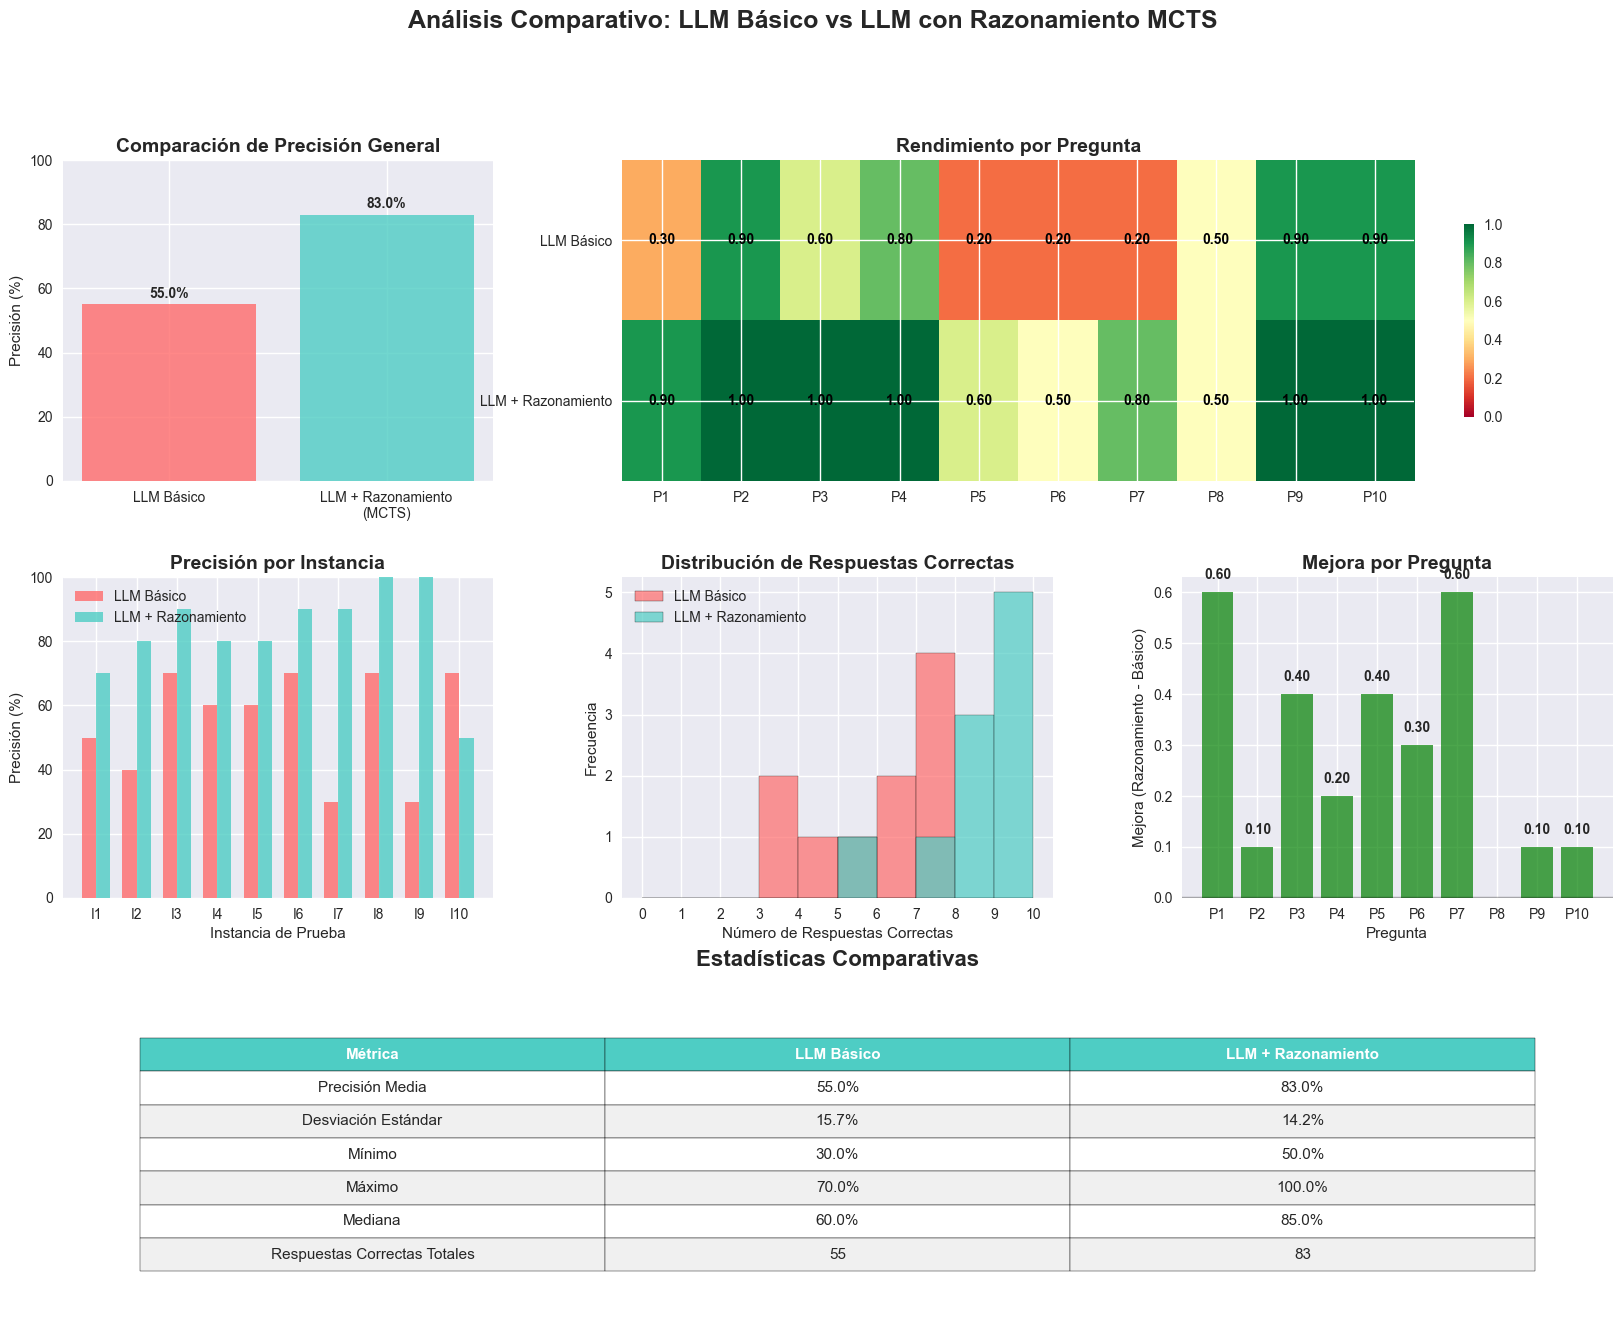

ANÁLISIS ESTADÍSTICO DETALLADO

1. PRECISIÓN GENERAL:
   LLM Básico: 55.0%
   LLM + Razonamiento: 83.0%
   Mejora: 28.0 puntos porcentuales

2. PRUEBA T DE STUDENT:
   t-statistic: 3.562
   p-value: 0.006
   Diferencia significativa: Sí

3. ANÁLISIS POR PREGUNTA:
   Pregunta 1: 30% → 90% (+60%)
   Pregunta 2: 90% → 100% (+10%)
   Pregunta 3: 60% → 100% (+40%)
   Pregunta 4: 80% → 100% (+20%)
   Pregunta 5: 20% → 60% (+40%)
   Pregunta 6: 20% → 50% (+30%)
   Pregunta 7: 20% → 80% (+60%)
   Pregunta 8: 50% → 50% (+0%)
   Pregunta 9: 90% → 100% (+10%)
   Pregunta 10: 90% → 100% (+10%)

4. CONSISTENCIA:
   LLM Básico - Desviación estándar: 15.7%
   LLM + Razonamiento - Desviación estándar: 14.2%
   Mejora en consistencia: 1.5 puntos


In [22]:
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from scipy import stats  
import pandas as pd 

# Convertir a arrays numpy para facilitar el análisis
llm_only_np = np.array(llm_only)
llm_reasoning_np = np.array(llm_reasoning)

# Configurar el estilo de las gráficas
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Crear figura con múltiples subplots
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Comparación de precisión general
ax1 = fig.add_subplot(gs[0, 0])
accuracy_llm = np.mean(llm_only_np) * 100
accuracy_reasoning = np.mean(llm_reasoning_np) * 100

bars = ax1.bar(['LLM Básico', 'LLM + Razonamiento\n(MCTS)'], 
               [accuracy_llm, accuracy_reasoning], 
               color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
ax1.set_ylabel('Precisión (%)')
ax1.set_title('Comparación de Precisión General', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 100)

# Añadir valores en las barras
for bar, value in zip(bars, [accuracy_llm, accuracy_reasoning]):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

# 2. Mapa de calor de rendimiento por pregunta
ax2 = fig.add_subplot(gs[0, 1:])
comparison_data = np.array([
    np.mean(llm_only_np, axis=0),
    np.mean(llm_reasoning_np, axis=0)
])

im = ax2.imshow(comparison_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax2.set_xticks(range(10))
ax2.set_xticklabels([f'P{i+1}' for i in range(10)])
ax2.set_yticks(range(2))
ax2.set_yticklabels(['LLM Básico', 'LLM + Razonamiento'])
ax2.set_title('Rendimiento por Pregunta', fontsize=14, fontweight='bold')

# Añadir valores en el mapa de calor
for i in range(2):
    for j in range(10):
        text = ax2.text(j, i, f'{comparison_data[i, j]:.2f}', 
                       ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im, ax=ax2, shrink=0.6)

# 3. Precisión por instancia/prueba
ax3 = fig.add_subplot(gs[1, 0])
instance_accuracy_llm = np.mean(llm_only_np, axis=1) * 100
instance_accuracy_reasoning = np.mean(llm_reasoning_np, axis=1) * 100

x_pos = np.arange(len(instance_accuracy_llm))
width = 0.35

bars1 = ax3.bar(x_pos - width/2, instance_accuracy_llm, width, 
                label='LLM Básico', color='#FF6B6B', alpha=0.8)
bars2 = ax3.bar(x_pos + width/2, instance_accuracy_reasoning, width, 
                label='LLM + Razonamiento', color='#4ECDC4', alpha=0.8)

ax3.set_xlabel('Instancia de Prueba')
ax3.set_ylabel('Precisión (%)')
ax3.set_title('Precisión por Instancia', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'I{i+1}' for i in range(len(instance_accuracy_llm))])
ax3.legend()
ax3.set_ylim(0, 100)

# 4. Distribución de respuestas correctas
ax4 = fig.add_subplot(gs[1, 1])
correct_counts_llm = np.sum(llm_only_np, axis=1)
correct_counts_reasoning = np.sum(llm_reasoning_np, axis=1)

ax4.hist(correct_counts_llm, bins=range(0, 11), alpha=0.7, 
         label='LLM Básico', color='#FF6B6B', edgecolor='black')
ax4.hist(correct_counts_reasoning, bins=range(0, 11), alpha=0.7, 
         label='LLM + Razonamiento', color='#4ECDC4', edgecolor='black')
ax4.set_xlabel('Número de Respuestas Correctas')
ax4.set_ylabel('Frecuencia')
ax4.set_title('Distribución de Respuestas Correctas', fontsize=14, fontweight='bold')
ax4.legend()
ax4.set_xticks(range(0, 11))

# 5. Mejora por pregunta
ax5 = fig.add_subplot(gs[1, 2])
improvement = np.mean(llm_reasoning_np, axis=0) - np.mean(llm_only_np, axis=0)
colors = ['green' if x > 0 else 'red' if x < 0 else 'gray' for x in improvement]

bars = ax5.bar(range(10), improvement, color=colors, alpha=0.7)
ax5.set_xlabel('Pregunta')
ax5.set_ylabel('Mejora (Razonamiento - Básico)')
ax5.set_title('Mejora por Pregunta', fontsize=14, fontweight='bold')
ax5.set_xticks(range(10))
ax5.set_xticklabels([f'P{i+1}' for i in range(10)])
ax5.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Añadir valores en las barras
for bar, value in zip(bars, improvement):
    if value != 0:
        ax5.text(bar.get_x() + bar.get_width()/2, 
                bar.get_height() + (0.02 if value > 0 else -0.05), 
                f'{value:.2f}', ha='center', va='bottom' if value > 0 else 'top', 
                fontweight='bold')

# 6. Estadísticas descriptivas
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('off')

# Calcular estadísticas
stats_data = {
    'Métrica': ['Precisión Media', 'Desviación Estándar', 'Mínimo', 'Máximo', 
                'Mediana', 'Respuestas Correctas Totales'],
    'LLM Básico': [
        f'{accuracy_llm:.1f}%',
        f'{np.std(instance_accuracy_llm):.1f}%',
        f'{np.min(instance_accuracy_llm):.1f}%',
        f'{np.max(instance_accuracy_llm):.1f}%',
        f'{np.median(instance_accuracy_llm):.1f}%',
        f'{np.sum(llm_only_np)}'
    ],
    'LLM + Razonamiento': [
        f'{accuracy_reasoning:.1f}%',
        f'{np.std(instance_accuracy_reasoning):.1f}%',
        f'{np.min(instance_accuracy_reasoning):.1f}%',
        f'{np.max(instance_accuracy_reasoning):.1f}%',
        f'{np.median(instance_accuracy_reasoning):.1f}%',
        f'{np.sum(llm_reasoning_np)}'
    ]
}

# Crear tabla
table_data = []
for i, metric in enumerate(stats_data['Métrica']):
    table_data.append([metric, stats_data['LLM Básico'][i], stats_data['LLM + Razonamiento'][i]])

table = ax6.table(cellText=table_data, 
                  colLabels=['Métrica', 'LLM Básico', 'LLM + Razonamiento'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.3, 0.3, 0.3])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Styling de la tabla
for i in range(len(table_data) + 1):
    for j in range(3):
        cell = table[(i, j)]
        if i == 0:  # Header
            cell.set_facecolor('#4ECDC4')
            cell.set_text_props(weight='bold', color='white')
        else:
            cell.set_facecolor('#F0F0F0' if i % 2 == 0 else 'white')

ax6.set_title('Estadísticas Comparativas', fontsize=16, fontweight='bold', pad=20)

plt.suptitle('Análisis Comparativo: LLM Básico vs LLM con Razonamiento MCTS', 
             fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

# Análisis estadístico adicional
print("="*60)
print("ANÁLISIS ESTADÍSTICO DETALLADO")
print("="*60)

print(f"\n1. PRECISIÓN GENERAL:")
print(f"   LLM Básico: {accuracy_llm:.1f}%")
print(f"   LLM + Razonamiento: {accuracy_reasoning:.1f}%")
print(f"   Mejora: {accuracy_reasoning - accuracy_llm:.1f} puntos porcentuales")

print(f"\n2. PRUEBA T DE STUDENT:")
t_stat, p_value = stats.ttest_rel(instance_accuracy_reasoning, instance_accuracy_llm)
print(f"   t-statistic: {t_stat:.3f}")
print(f"   p-value: {p_value:.3f}")
print(f"   Diferencia significativa: {'Sí' if p_value < 0.05 else 'No'}")

print(f"\n3. ANÁLISIS POR PREGUNTA:")
for i in range(10):
    llm_acc = np.mean(llm_only_np[:, i]) * 100
    reasoning_acc = np.mean(llm_reasoning_np[:, i]) * 100
    improvement = reasoning_acc - llm_acc
    print(f"   Pregunta {i+1}: {llm_acc:.0f}% → {reasoning_acc:.0f}% ({improvement:+.0f}%)")

print(f"\n4. CONSISTENCIA:")
print(f"   LLM Básico - Desviación estándar: {np.std(instance_accuracy_llm):.1f}%")
print(f"   LLM + Razonamiento - Desviación estándar: {np.std(instance_accuracy_reasoning):.1f}%")
print(f"   Mejora en consistencia: {np.std(instance_accuracy_llm) - np.std(instance_accuracy_reasoning):.1f} puntos")

C:\Users\Zkorpion\AppData\Local\Temp\ipykernel_9808\316842890.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


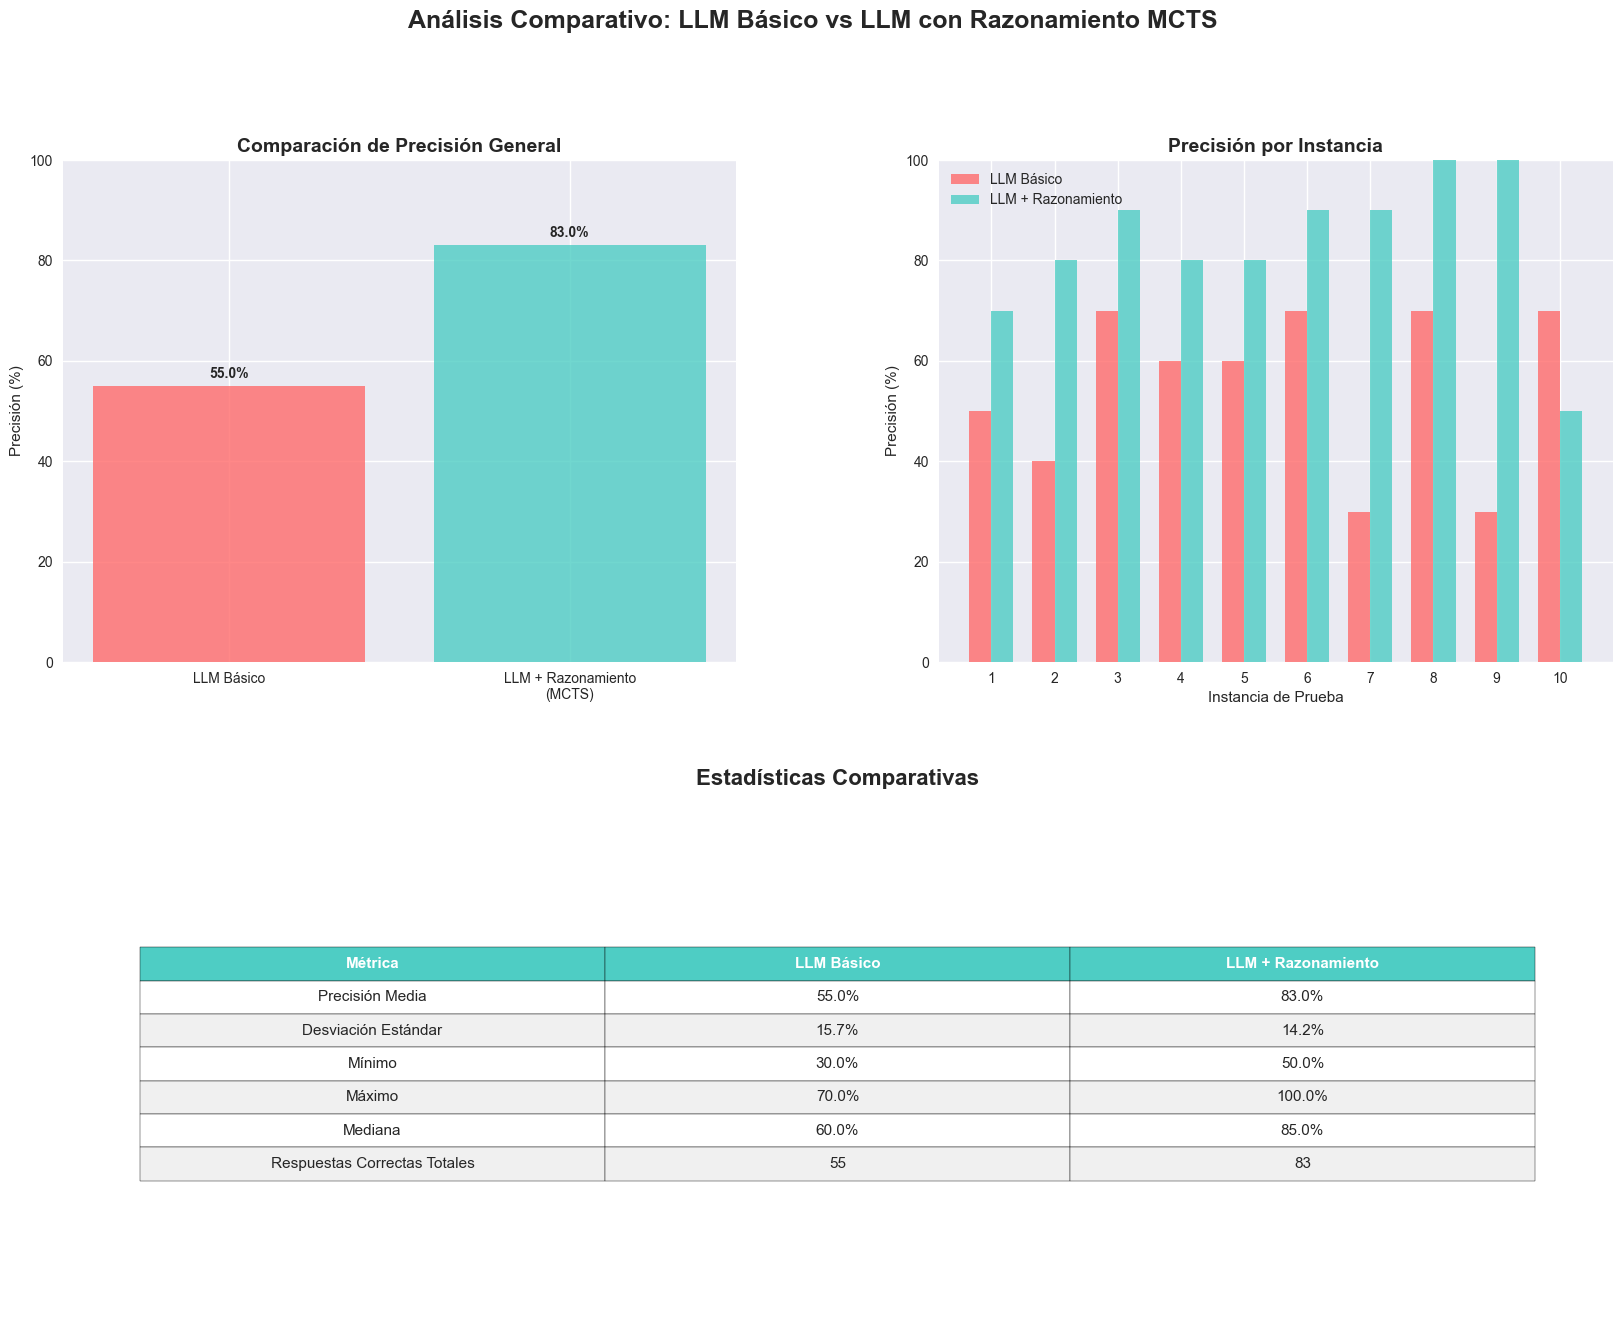

In [23]:
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from scipy import stats  
import pandas as pd 

# Convertir a arrays numpy para facilitar el análisis
llm_only_np = np.array(llm_only)
llm_reasoning_np = np.array(llm_reasoning)

# Configurar el estilo de las gráficas
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Crear figura con múltiples subplots
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)


# 1. Comparación de precisión general
ax1 = fig.add_subplot(gs[0, 0])
accuracy_llm = np.mean(llm_only_np) * 100
accuracy_reasoning = np.mean(llm_reasoning_np) * 100

bars = ax1.bar(['LLM Básico', 'LLM + Razonamiento\n(MCTS)'], 
               [accuracy_llm, accuracy_reasoning], 
               color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
ax1.set_ylabel('Precisión (%)')
ax1.set_title('Comparación de Precisión General', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 100)


# Añadir valores en las barras
for bar, value in zip(bars, [accuracy_llm, accuracy_reasoning]):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')


# 2. Mapa de calor de rendimiento por pregunta
ax3 = fig.add_subplot(gs[0,1])
instance_accuracy_llm = np.mean(llm_only_np, axis=1) * 100
instance_accuracy_reasoning = np.mean(llm_reasoning_np, axis=1) * 100

x_pos = np.arange(len(instance_accuracy_llm))
width = 0.35

bars1 = ax3.bar(x_pos - width/2, instance_accuracy_llm, width, 
                label='LLM Básico', color='#FF6B6B', alpha=0.8)
bars2 = ax3.bar(x_pos + width/2, instance_accuracy_reasoning, width, 
                label='LLM + Razonamiento', color='#4ECDC4', alpha=0.8)

ax3.set_xlabel('Instancia de Prueba')
ax3.set_ylabel('Precisión (%)')
ax3.set_title('Precisión por Instancia', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'{i+1}' for i in range(len(instance_accuracy_llm))])
ax3.legend()
ax3.set_ylim(0, 100)

ax6 = fig.add_subplot(gs[1, :])
ax6.axis('off')

# Calcular estadísticas
stats_data = {
    'Métrica': ['Precisión Media', 'Desviación Estándar', 'Mínimo', 'Máximo', 
                'Mediana', 'Respuestas Correctas Totales'],
    'LLM Básico': [
        f'{accuracy_llm:.1f}%',
        f'{np.std(instance_accuracy_llm):.1f}%',
        f'{np.min(instance_accuracy_llm):.1f}%',
        f'{np.max(instance_accuracy_llm):.1f}%',
        f'{np.median(instance_accuracy_llm):.1f}%',
        f'{np.sum(llm_only_np)}'
    ],
    'LLM + Razonamiento': [
        f'{accuracy_reasoning:.1f}%',
        f'{np.std(instance_accuracy_reasoning):.1f}%',
        f'{np.min(instance_accuracy_reasoning):.1f}%',
        f'{np.max(instance_accuracy_reasoning):.1f}%',
        f'{np.median(instance_accuracy_reasoning):.1f}%',
        f'{np.sum(llm_reasoning_np)}'
    ]
}

# Crear tabla
table_data = []
for i, metric in enumerate(stats_data['Métrica']):
    table_data.append([metric, stats_data['LLM Básico'][i], stats_data['LLM + Razonamiento'][i]])

table = ax6.table(cellText=table_data, 
                  colLabels=['Métrica', 'LLM Básico', 'LLM + Razonamiento'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.3, 0.3, 0.3])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Styling de la tabla
for i in range(len(table_data) + 1):
    for j in range(3):
        cell = table[(i, j)]
        if i == 0:  # Header
            cell.set_facecolor('#4ECDC4')
            cell.set_text_props(weight='bold', color='white')
        else:
            cell.set_facecolor('#F0F0F0' if i % 2 == 0 else 'white')

ax6.set_title('Estadísticas Comparativas', fontsize=16, fontweight='bold', pad=20)

plt.suptitle('Análisis Comparativo: LLM Básico vs LLM con Razonamiento MCTS', 
             fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()
